# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

### Import Packages

In [1]:
# These are most of what we need
import math
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

### Let's see what we are dealing with first
We will plot all the images found in the folder

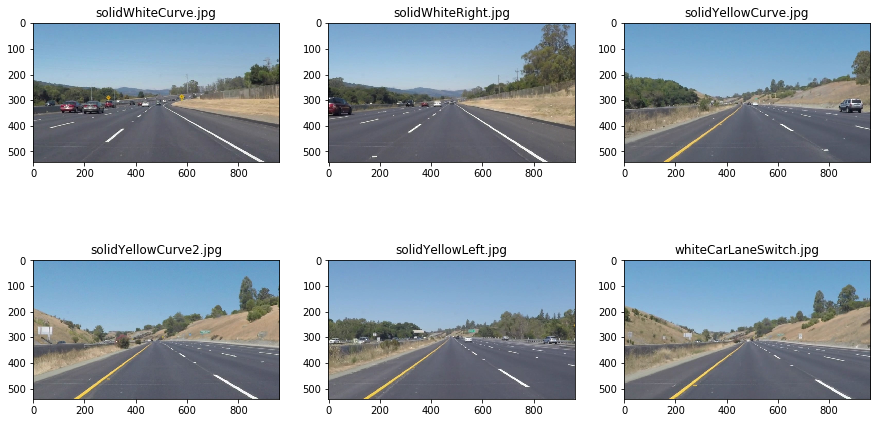

In [2]:
folder_name = 'test_images/'
img_files = os.listdir(folder_name)

fig = plt.figure(figsize=(15,8))
count = len(img_files)
col = 3
row = int(count / col) + (count % col)
item = 0

for file in img_files:
    item += 1
    path = folder_name + file
    img = cv2.imread(path)
    fig.add_subplot(row, col, item)
    plt.title(file)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Inspection
So we have 6 different test images, with either left or right lane as solid line as well as yellow and white in color

### Helper Functions
Some basic help functions

In [3]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
#     return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# The improved version is in below section
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, thickness=2):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, thickness=2)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

### Build a Lane Finding Pipeline

#### Canny Edge
Build a basic lane finding pipeline that will roughly find the lane to start with. First work inspect Canny Edge

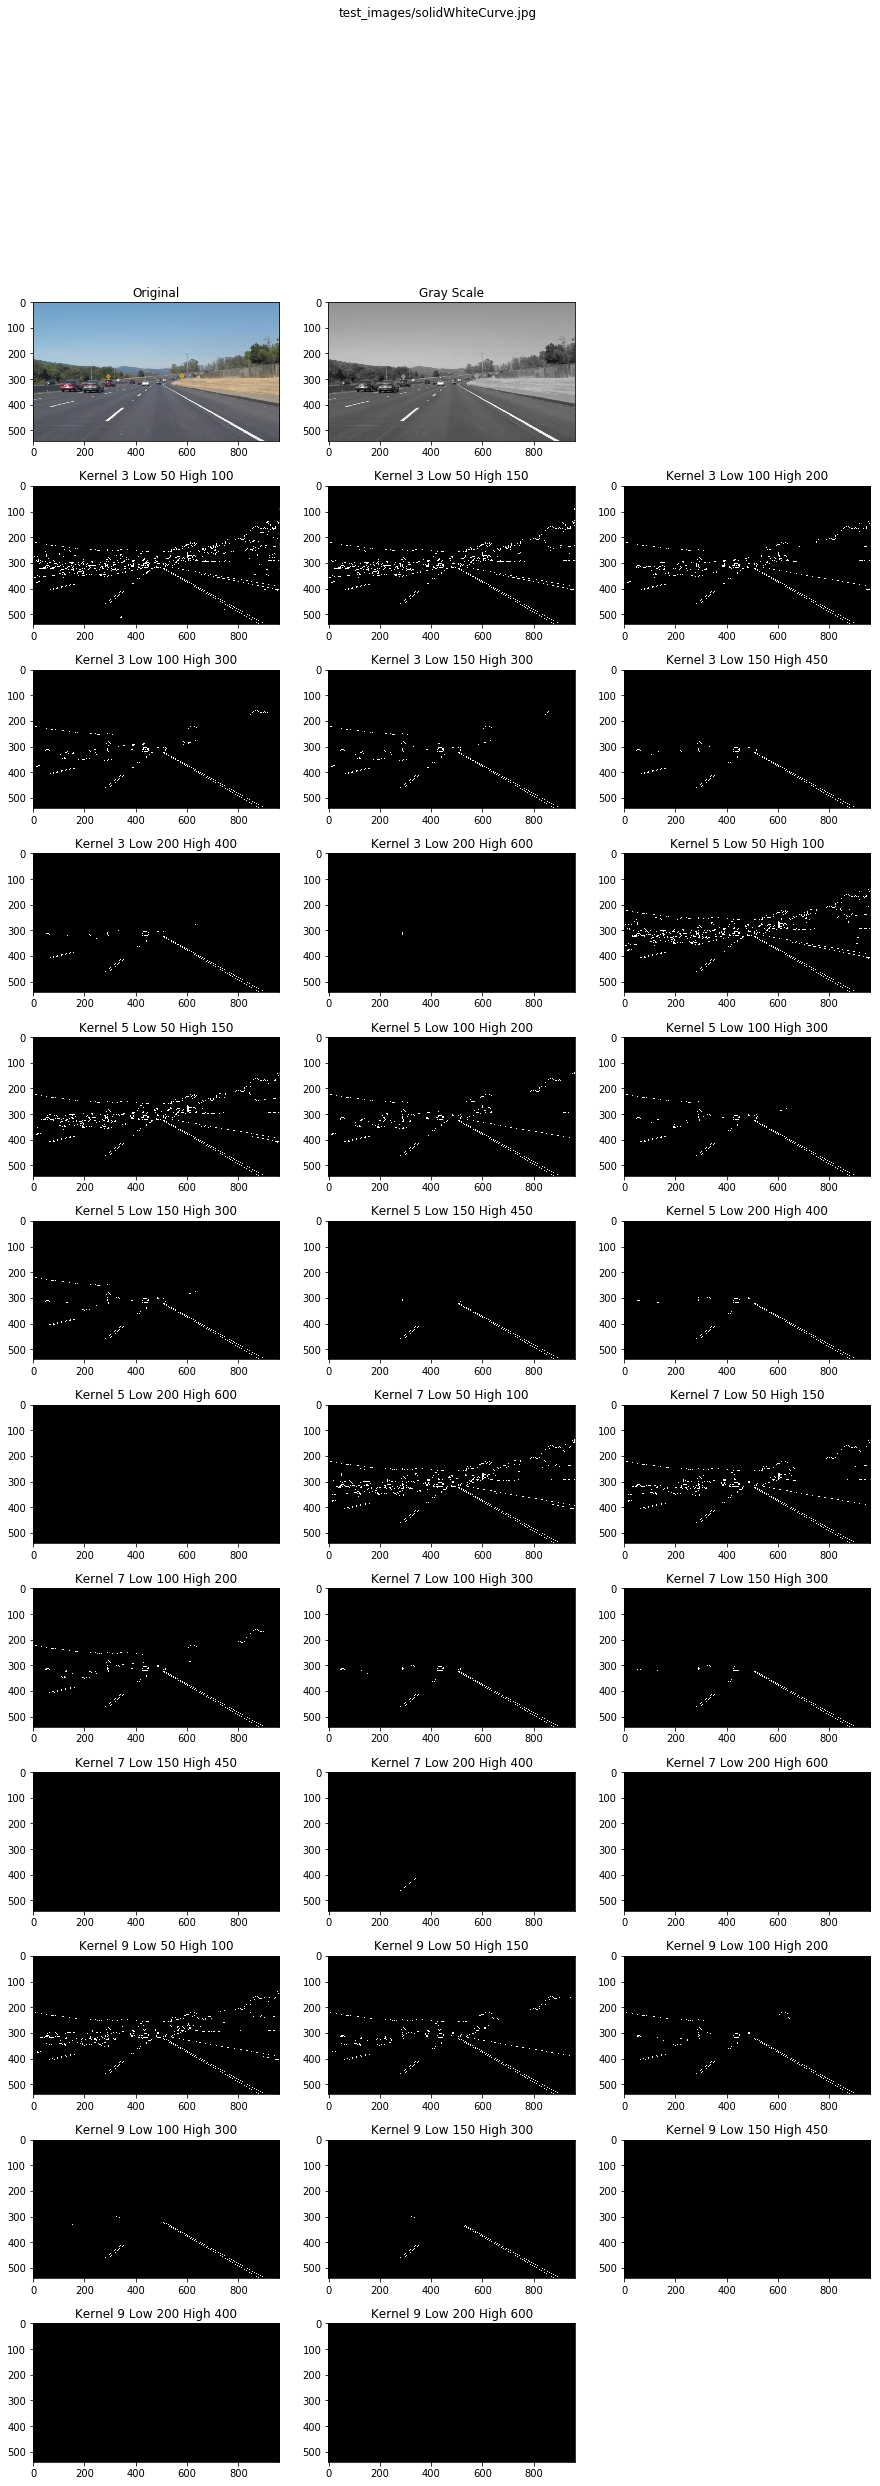

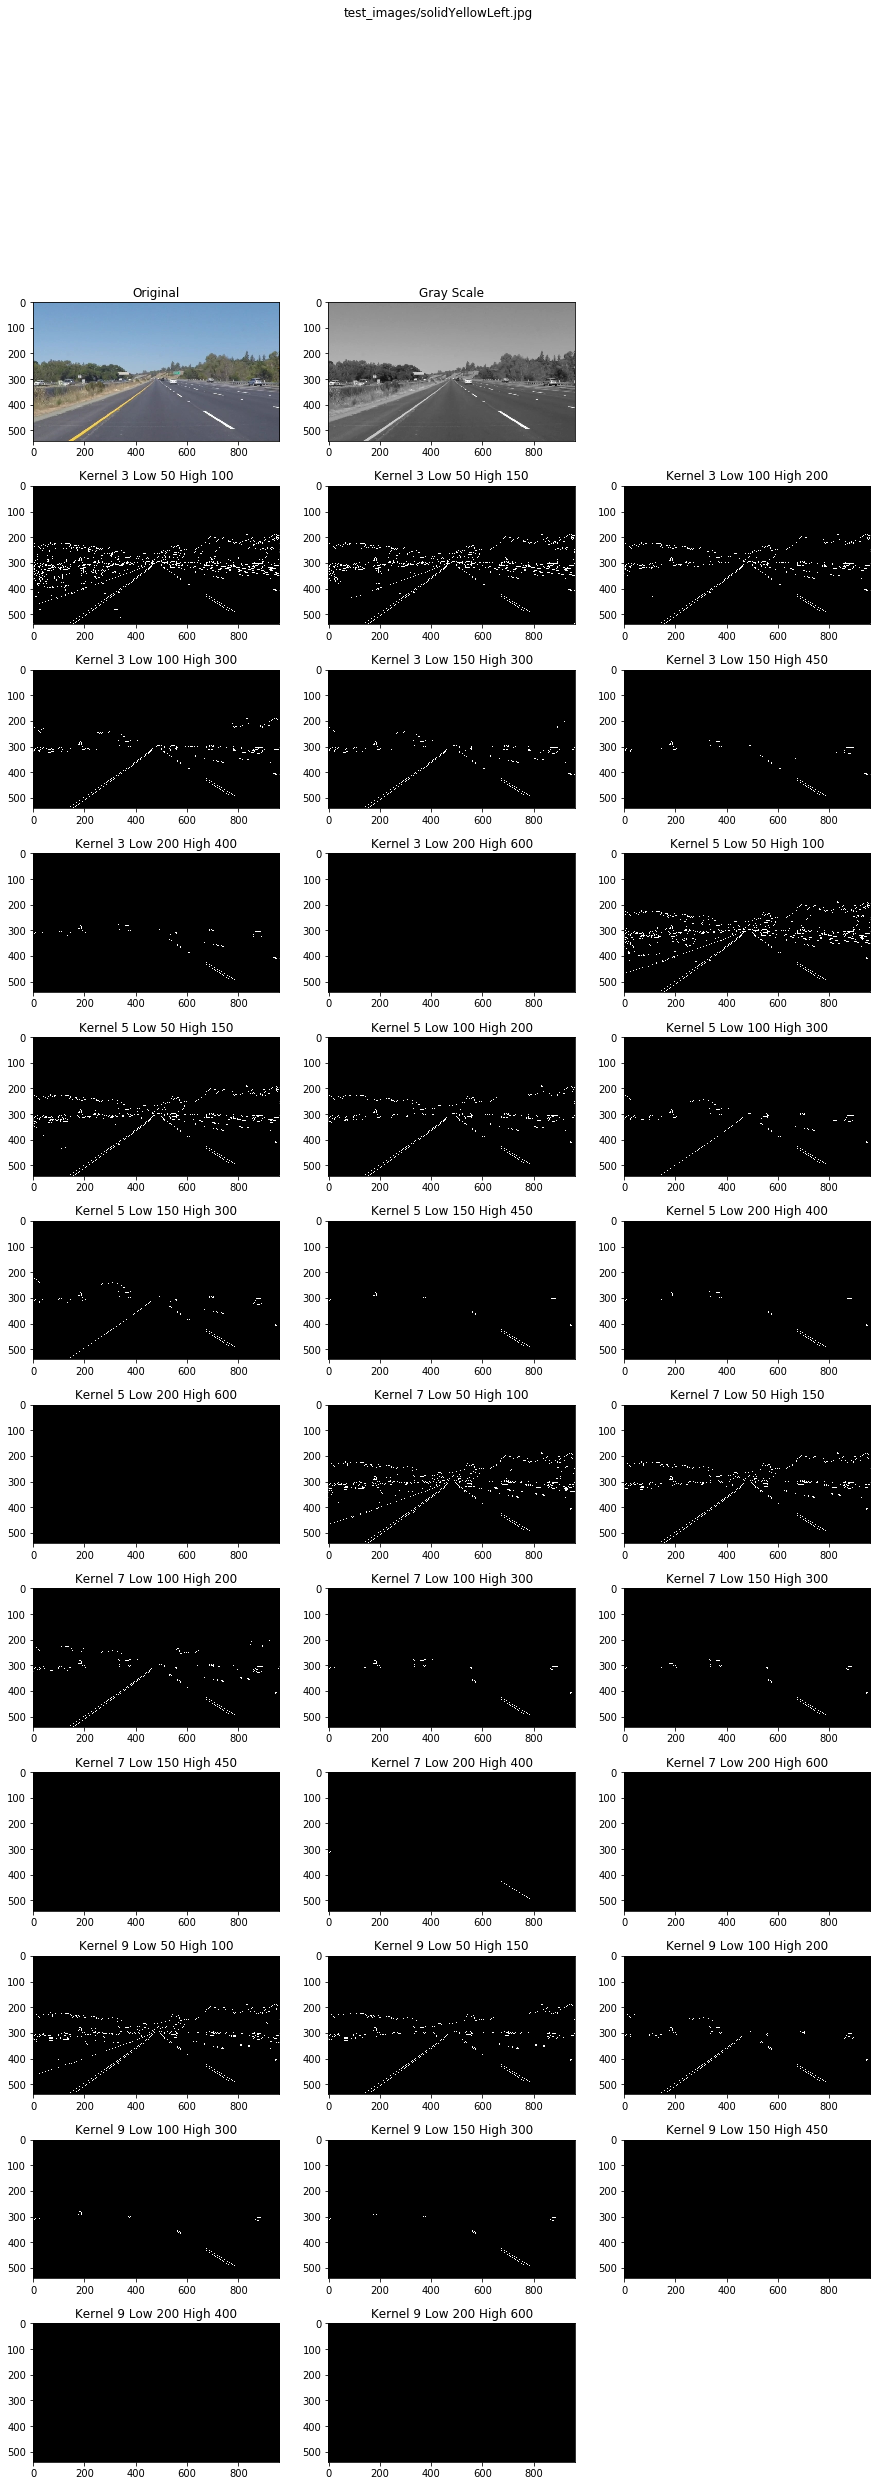

In [4]:
# Try to loop through some different parameter settings and see if there is any good one
def inspect_plot(img_path):
    fig = plt.figure(figsize=(15,40))
    fig.suptitle(img_path, fontsize=12)
    
    col = 3
    row = 12
    count = 0
    
    img = cv2.imread(img_path)
    count += 1
    fig.add_subplot(row, col, count)
    plt.title('Original')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    gray_img = grayscale(img)
    count += 1
    fig.add_subplot(row, col, count)
    plt.title('Gray Scale')
    plt.imshow(gray_img, cmap='gray')
    
    # Skip the 3rd image
    count = 3
    
    base_thresholds = [50,100,150,200]
    
    for k in range(1,5):
        for base in base_thresholds:
            for threshold_ratio in range (2,4): # This will give 1:2 and 1:3
                # Calculate the basic
                kernel_size = 1 + k * 2
                low_threshold = base
                high_threshold = low_threshold * threshold_ratio
                
                # Process it
                blur_img = gaussian_blur(gray_img, kernel_size)
                canny_img = canny(blur_img, low_threshold, high_threshold)
                
                # Plot the result
                count += 1
                fig.add_subplot(row, col, count)
                plt.title('Kernel {} Low {} High {}'.format(kernel_size, low_threshold, high_threshold))
                plt.imshow(canny_img, cmap='gray')
    
img_files = ['solidWhiteCurve.jpg', 'solidYellowLeft.jpg'] # Pick some samples
    
for file in img_files:
    path = folder_name + file
    inspect_plot(path)

Look like the following paramters give a decent result at this stage

* kernel = 5
* low_threshold = 100
* high_threshold = 200

Let's try to run on all test images and see

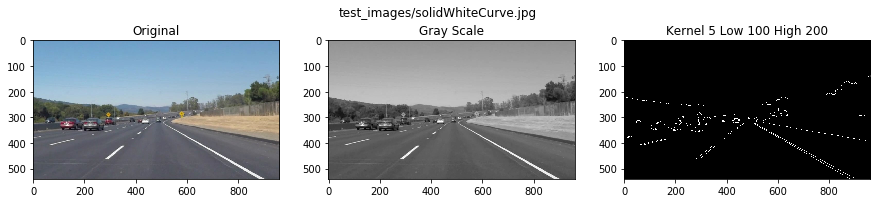

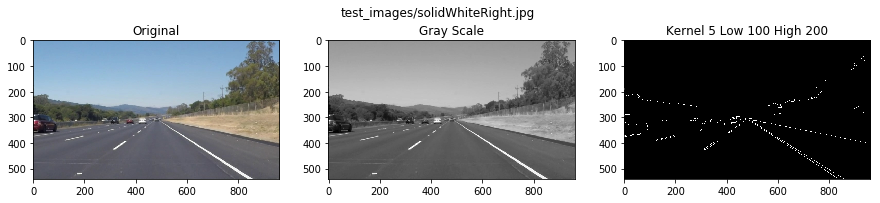

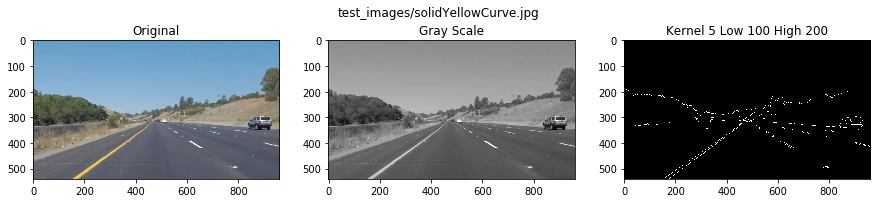

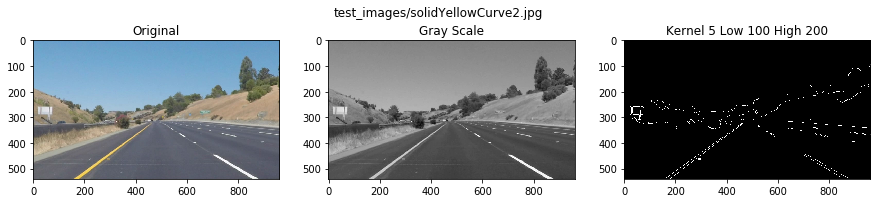

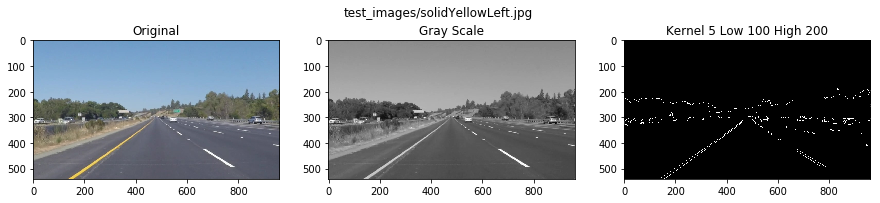

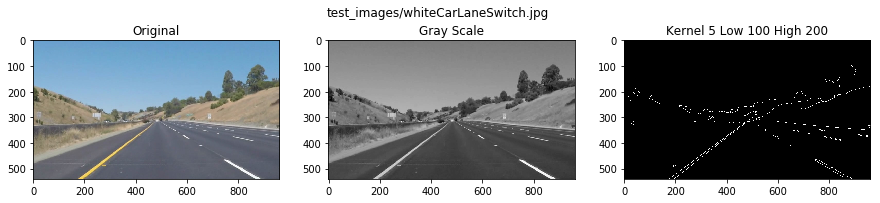

In [5]:
# Try to loop through some different parameter settings and see if there is any good one
def inspect_canny_plot_fixed_parameters(img_path, kernel_size=5, low_threshold=100, high_threshold=200):
    fig = plt.figure(figsize=(15,3))
    fig.suptitle(img_path, fontsize=12)
    
    col = 3
    row = 1
    count = 0
    
    img = cv2.imread(img_path)
    count += 1
    fig.add_subplot(row, col, count)
    plt.title('Original')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    gray_img = grayscale(img)
    count += 1
    fig.add_subplot(row, col, count)
    plt.title('Gray Scale')
    plt.imshow(gray_img, cmap='gray')
    
    # Process it
    blur_img = gaussian_blur(gray_img, kernel_size)
    canny_img = canny(blur_img, low_threshold, high_threshold)

    # Plot the result
    count += 1
    fig.add_subplot(row, col, count)
    plt.title('Kernel {} Low {} High {}'.format(kernel_size, low_threshold, high_threshold))
    plt.imshow(canny_img, cmap='gray')
    
# img_files = ['solidWhiteCurve.jpg', 'solidYellowLeft.jpg'] # Pick some samples
img_files = os.listdir(folder_name)

# Define the paramters
kernel_size = 5
low_threshold = 100
high_threshold = 200

for file in img_files:
    path = folder_name + file
    inspect_canny_plot_fixed_parameters(path, kernel_size, low_threshold, high_threshold)

So far so good for Canny Edge on all test images

#### Region of Interest
We don't need everything on the images, let zoom out the area we need

In [6]:
# Since we start to deal with a more complex pipeline, we need to create more helper for ease of use
def get_canny_edge(img, kernel_size=5, low_threshold=100, high_threshold=200):
    gray_img = grayscale(img)
    blur_img = gaussian_blur(gray_img, kernel_size)
    canny_img = canny(blur_img, low_threshold, high_threshold)
    return canny_img

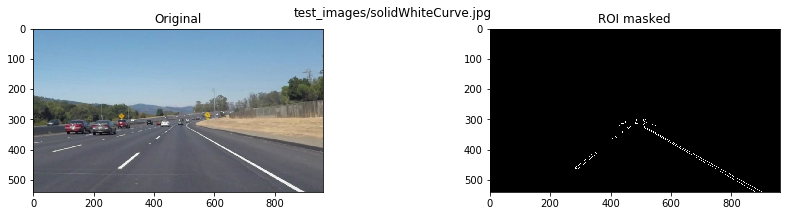

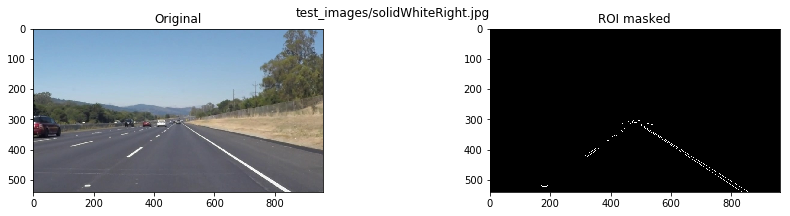

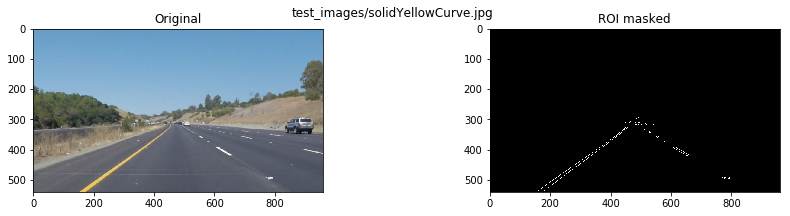

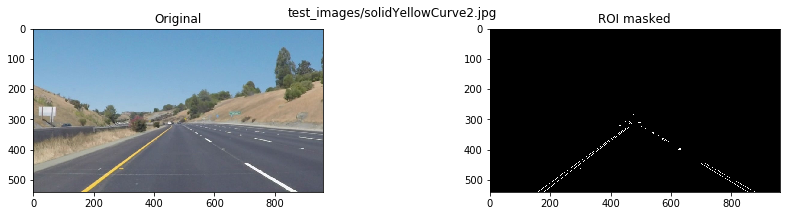

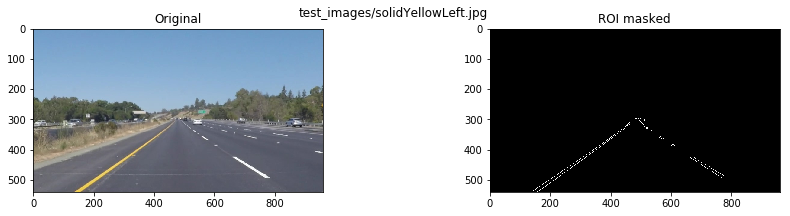

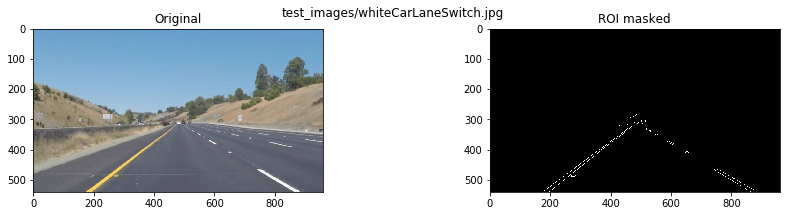

In [7]:
def inspect_roi_plot(img_path, vertices, kernel_size=5, low_threshold=100, high_threshold=200):
    fig = plt.figure(figsize=(15,3))
    fig.suptitle(img_path, fontsize=12)
    
    col = 2
    row = 1
    count = 0
    
    img = cv2.imread(img_path)
    canny_img = get_canny_edge(img, kernel_size, low_threshold, high_threshold)
    roi_img = region_of_interest(canny_img, [vertices])
    
    # Plot the result
    count += 1
    fig.add_subplot(row, col, count)
    plt.title('Original')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    count += 1
    fig.add_subplot(row, col, count)
    plt.title('ROI masked')
    plt.imshow(roi_img, cmap='gray')

# Parameters for Region of Interest
left_bottom = [130, 539]
right_bottom = [920, 539]
apex = [480, 280]

x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]

vertices = np.array([left_bottom, right_bottom, apex])

img_files = os.listdir(folder_name)

for file in img_files:
    path = folder_name + file
    inspect_roi_plot(path, vertices, kernel_size, low_threshold, high_threshold)


Pretty clean result for ROI

#### Hough Lines
Let's overlay the high line result on the original and see

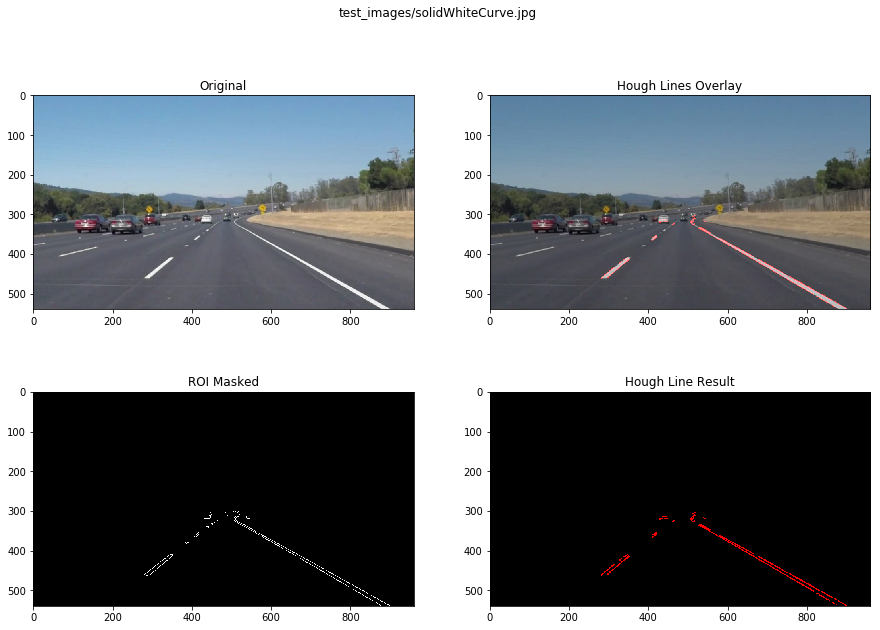

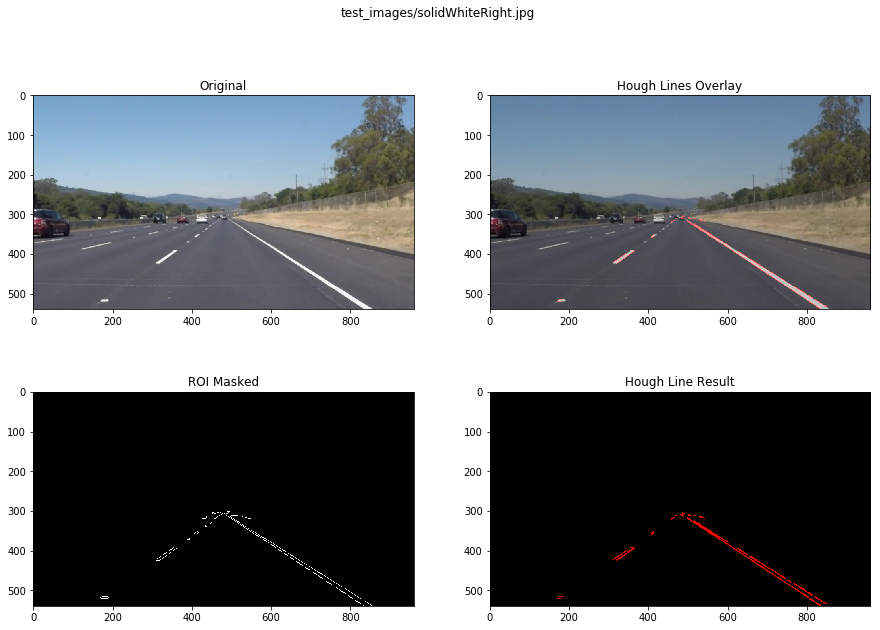

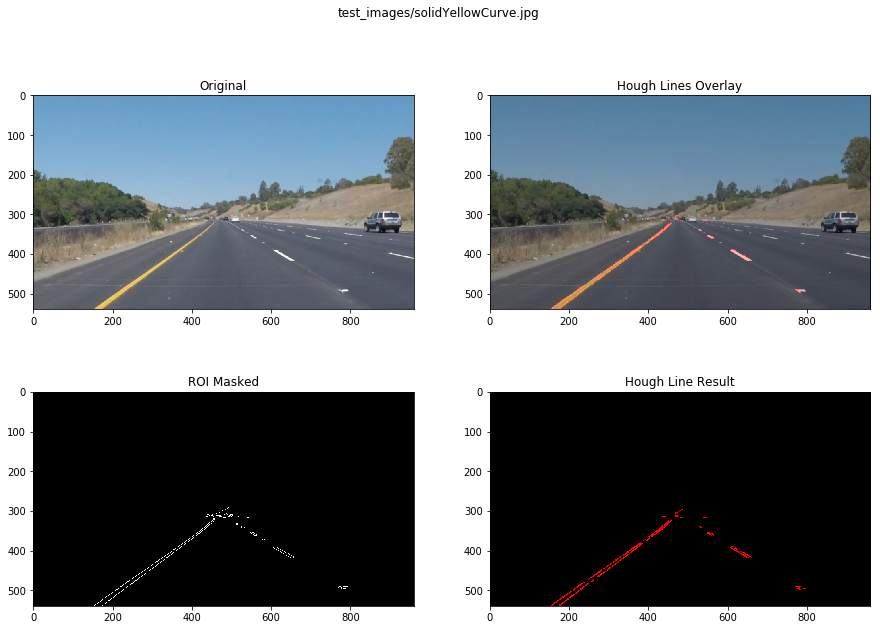

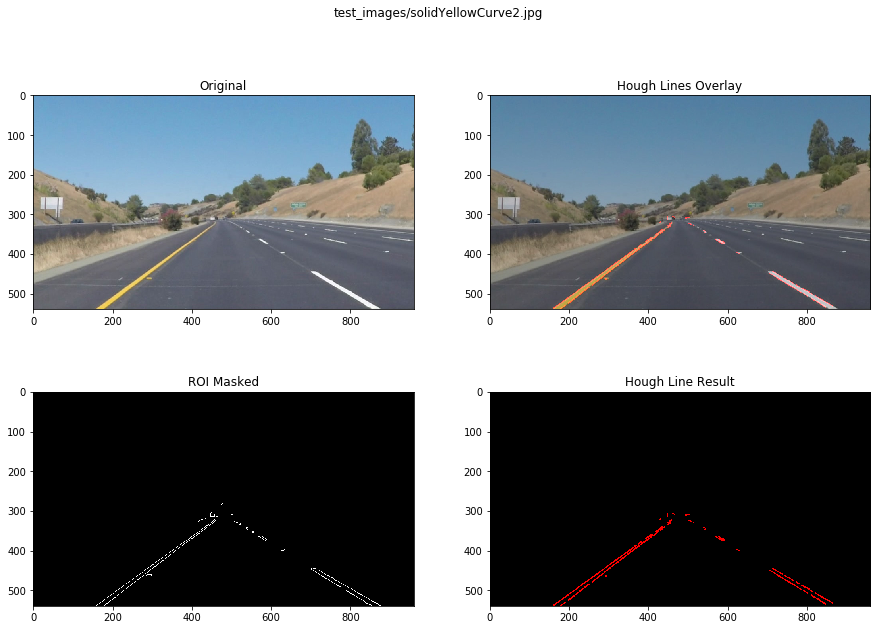

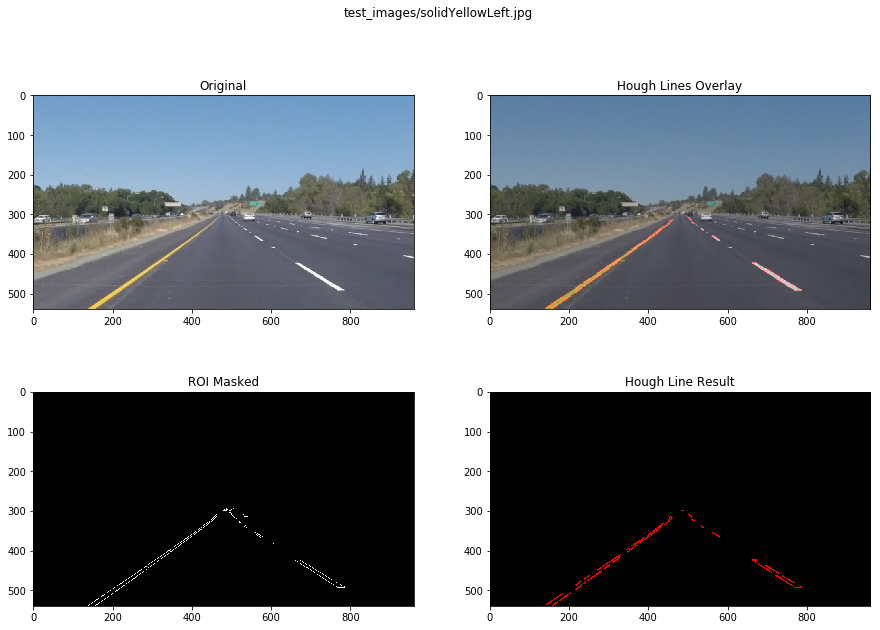

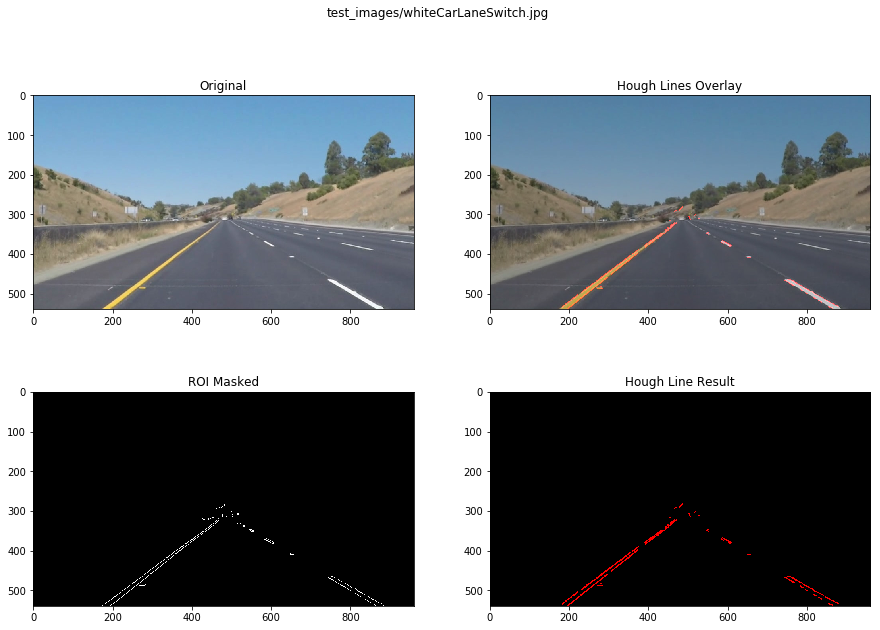

In [8]:
def inspect_hough_lines_plot(img_path):
    # Read image
    img = cv2.imread(img_path)
    
    # Process it
    canny_img = get_canny_edge(img, kernel_size, low_threshold, high_threshold)
    roi_img = region_of_interest(canny_img, [vertices])
    hough_lines_img = hough_lines(roi_img,rho,theta,threshold,min_line_length,max_line_gap)
    
    # Overlay the result
    overlay_img = weighted_img(hough_lines_img, cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    fig = plt.figure(figsize=(15,10))
    fig.suptitle(img_path, fontsize=12)
    
    col = 2
    row = 2
    count = 0
    
    # Plot the result
    count += 1
    fig.add_subplot(row, col, count)
    plt.title('Original')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    count += 1
    fig.add_subplot(row, col, count)
    plt.title('Hough Lines Overlay')
    plt.imshow(overlay_img)

    count += 1
    fig.add_subplot(row, col, count)
    plt.title('ROI Masked')
    plt.imshow(roi_img, cmap='gray')

    count += 1
    fig.add_subplot(row, col, count)
    plt.title('Hough Line Result')
    plt.imshow(hough_lines_img)
    
    
# Hough Lines Parameters
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 1     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 5 #minimum number of pixels making up a line
max_line_gap = 1    # maximum gap in pixels between connectable line segments
        
for file in img_files:
    path = folder_name + file
    inspect_hough_lines_plot(path)

So hough lines works resonably well on all testing images here

#### Draw a segmented lane on image for fulfill the Project Rubric

First work on images, the apply them on video


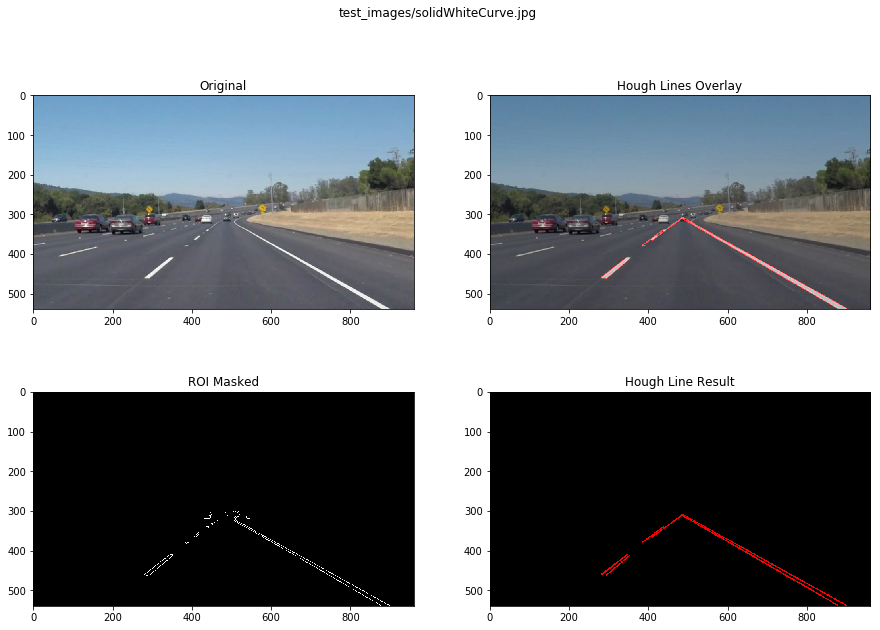

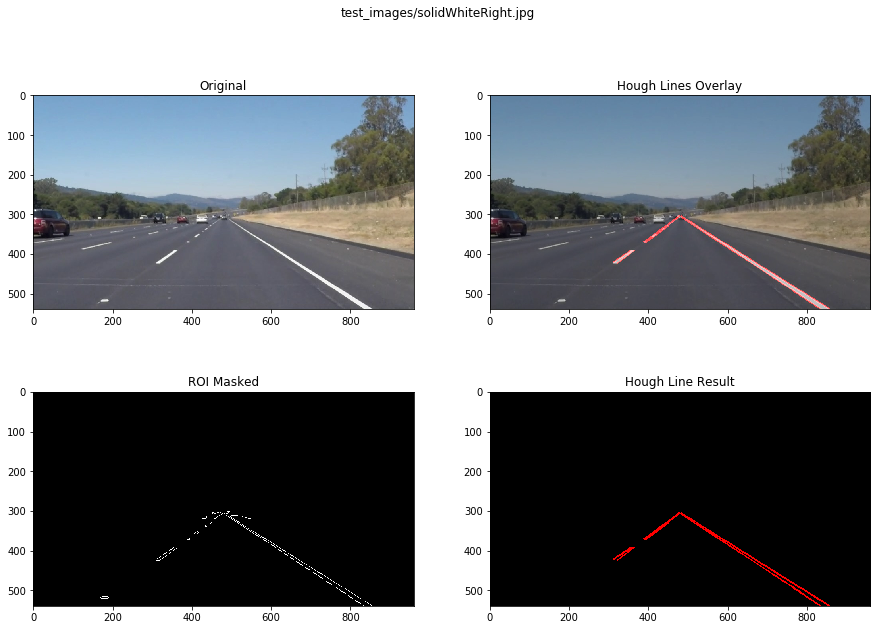

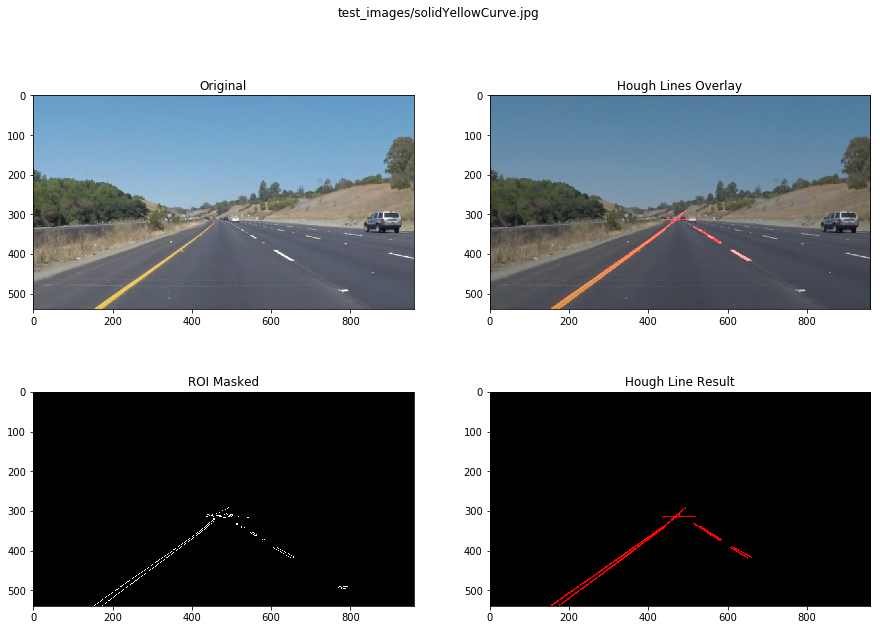

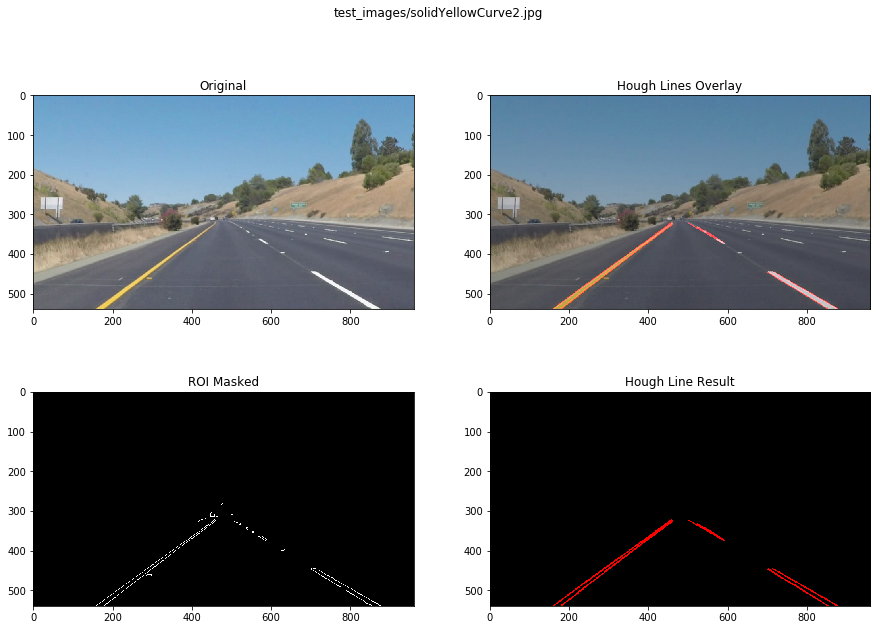

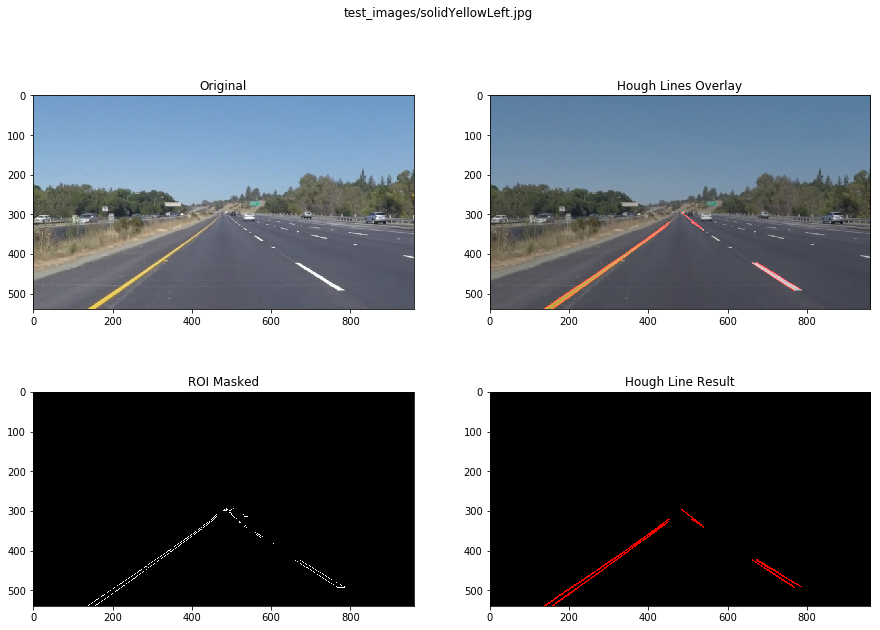

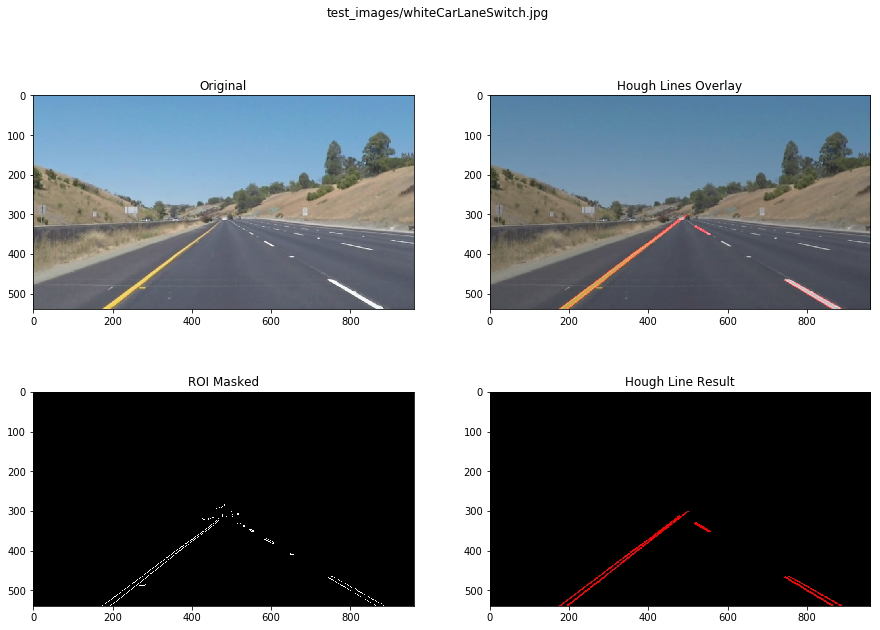

In [9]:
def inspect_rough_lane_plot(img_path):
    # Read image
    img = cv2.imread(img_path)
    
    # Process it
    canny_img = get_canny_edge(img, kernel_size, low_threshold, high_threshold)
    roi_img = region_of_interest(canny_img, [vertices])
    hough_lines_img = hough_lines(roi_img,rho,theta,threshold,min_line_length,max_line_gap)
    
    # Overlay the result
    overlay_img = weighted_img(hough_lines_img, cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    fig = plt.figure(figsize=(15,10))
    fig.suptitle(img_path, fontsize=12)
    
    col = 2
    row = 2
    count = 0
    
    # Plot the result
    count += 1
    fig.add_subplot(row, col, count)
    plt.title('Original')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    count += 1
    fig.add_subplot(row, col, count)
    plt.title('Hough Lines Overlay')
    plt.imshow(overlay_img)

    count += 1
    fig.add_subplot(row, col, count)
    plt.title('ROI Masked')
    plt.imshow(roi_img, cmap='gray')

    count += 1
    fig.add_subplot(row, col, count)
    plt.title('Hough Line Result')
    plt.imshow(hough_lines_img)
    
    
# Hough Lines Parameters
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 50     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 30 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments
        
for file in img_files:
# file = 'solidWhiteCurve.jpg'
    path = folder_name + file
    inspect_rough_lane_plot(path)

Images looks decent. Let's put it together and apply on video

In [10]:
def find_lane_rough(img):
    
    # Process it
    canny_img = get_canny_edge(img, kernel_size, low_threshold, high_threshold)
    roi_img = region_of_interest(canny_img, [vertices])
    hough_lines_img = hough_lines(roi_img,rho,theta,threshold,min_line_length,max_line_gap)
    
    # Overlay the result
    overlay_img = weighted_img(hough_lines_img, img)
    
    return overlay_img

# Hough Lines Parameters 
# For fine tuning on video
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 50     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 30 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments

rough_output = 'test_videos_output/solidWhiteRight_rough.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
rough_clip = clip1.fl_image(find_lane_rough)
%time rough_clip.write_videofile(rough_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight_rough.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight_rough.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:04<00:00, 54.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight_rough.mp4 

Wall time: 4.84 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(rough_output))

Looking ok on video too.

### Improve the draw_lines() function 
Need to improve the current draw_lines() function to drawe a solid line like in the P1_exmple.mp4.

#### Working image again before the video

The basic idea to draw a line amount all the point found is using liner regression to find the best fit line for all 
points generated from Hough Lines

In [12]:
# Help function
def slope(x1, y1, x2, y2):
    line_slope = ((y2-y1)/(x2-x1))
    return line_slope

def find_line(lines):
    # Find best fit line with liner regression
    # y = mx + b
    m, b = 1, 1
    line_found = False
    
    lines_x = []
    lines_y = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            lines_x.append(x1)
            lines_x.append(x2)
            lines_y.append(y1)
            lines_y.append(y2)
            
    if len(lines_x) > 0:
        m, b = np.polyfit(lines_x, lines_y, 1)
        line_found = True
        
    return m, b, line_found

# The core of this lane finding pipelin
def draw_lines_smooth(img, lines, color=[255, 0, 0], thickness=10):
    thickness=10


    slope_threshold = 0.5
    new_lines = []
    slopes = []


    for line in lines:
        for x1,y1,x2,y2 in line:
            
            if x2 - x1 == 0: # special case
                line_slope = 9999
            else:
                line_slope = slope(x1,y1,x2,y2)
            
            abs_line_slope = abs(line_slope)
#             print("x1=%.2f y1=%.2f x2=%.2f y2=%.2f slope=%.2f" % (x1,y1,x2,y2,abs_line_slope))
            
            # We don't care about other thing
            if abs_line_slope > slope_threshold:
                new_lines.append(line)
                slopes.append(line_slope)
                
    lines = new_lines
    img_center_line = img.shape[1] / 2
    left_lines = []
    right_lines = []
    
#     print('=== Lines After Slope Check === {}'.format(len(lines)))
    
    # Split the lines between left and right
    for i, line in enumerate(lines):
        for x1,y1,x2,y2 in line:
            if slopes[i] > 0 and x1 > img_center_line and x2 > img_center_line:
                right_lines.append(line)
            if slopes[i] < 0 and x1 < img_center_line and x2 < img_center_line:
                left_lines.append(line)
                
#     print('=== Right Lines === {}'.format(len(right_lines)))
#     print('=== Left Lines === {}'.format(len(left_lines)))
#     print('==== thickness ==== {}'.format(thickness))
            
    # Try to find line for each side
    left_m, left_b, left_line_found = find_line(left_lines)
    right_m, right_b, right_line_found = find_line(right_lines)
    
    # Find end point for left and right lines for drawing
    # y = mx + b
    # Transform to below
    # x = (y - b) / m
    #
    y1 = img.shape[0]
    y2 = int(img.shape[0] * 0.6) # factor as gussed from the apex analysis
    
    right_x1 = int((y1 - right_b) / right_m)
    right_x2 = int((y2 - right_b) / right_m)
    
    left_x1 = int((y1 - left_b) / left_m)
    left_x2 = int((y2 - left_b) / left_m)
    
    # Draw the right and left lines on image
    if right_line_found:
        cv2.line(img, (right_x1, y1), (right_x2, y2), color, thickness)
    if left_line_found:
        cv2.line(img, (left_x1, y1), (left_x2, y2), color, thickness)
        
def hough_lines_smooth(img, rho, theta, threshold, min_line_len, max_line_gap, thickness=2):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_smooth(line_img, lines, thickness=2)
    return line_img

In [13]:
def find_lane(img):
    # Process it
    canny_img = get_canny_edge(img, kernel_size, low_threshold, high_threshold)
    roi_img = region_of_interest(canny_img, [vertices])
    hough_lines_img = hough_lines_smooth(roi_img,rho,theta,threshold,min_line_length,max_line_gap)
    
    # Overlay the result
    overlay_img = weighted_img(hough_lines_img, img)
    
    return overlay_img

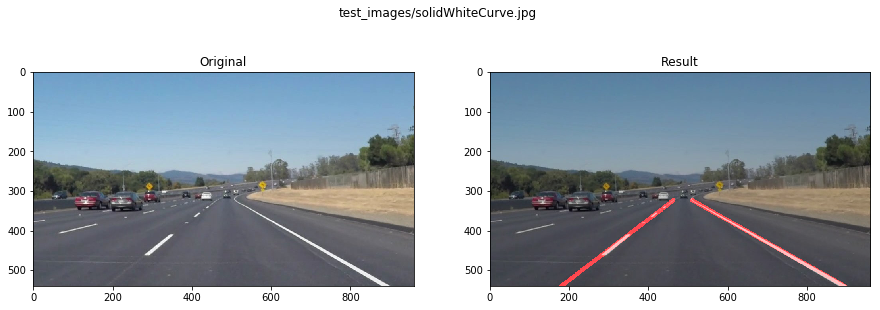

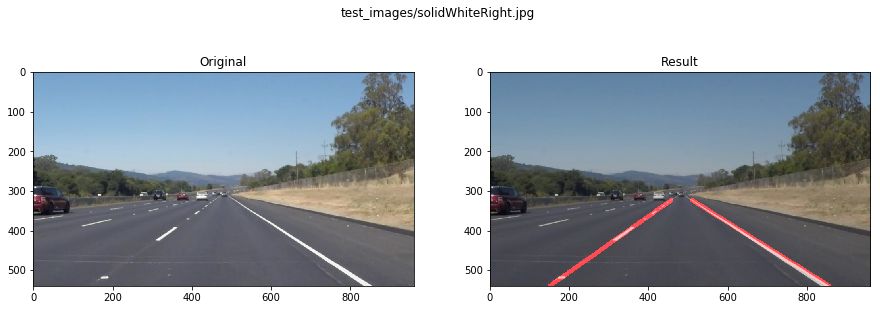

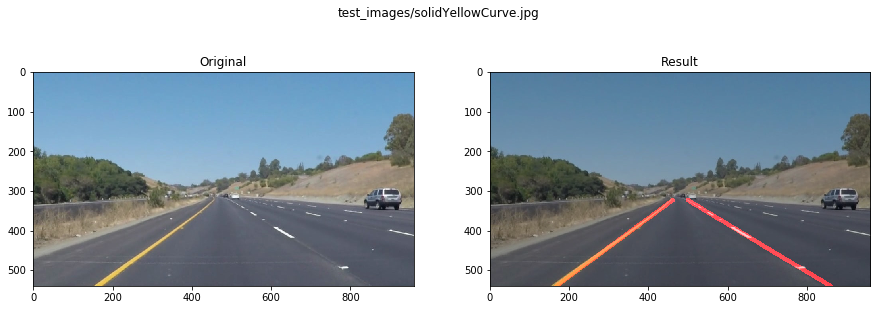

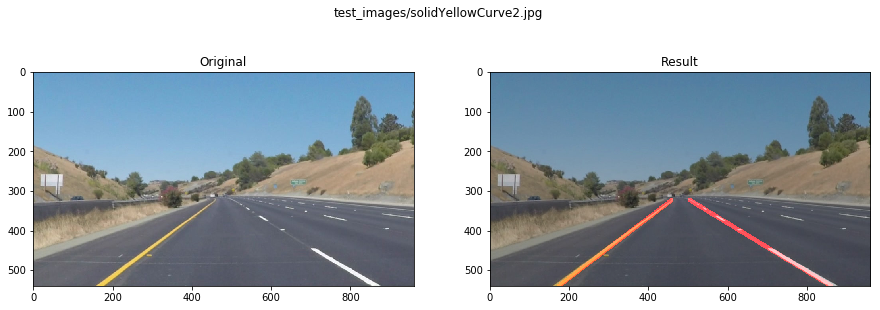

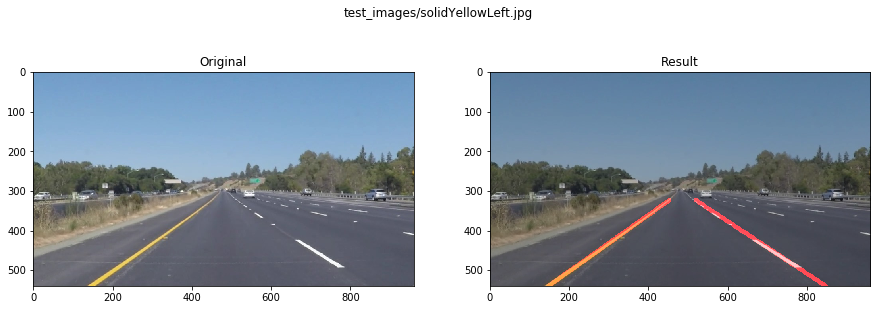

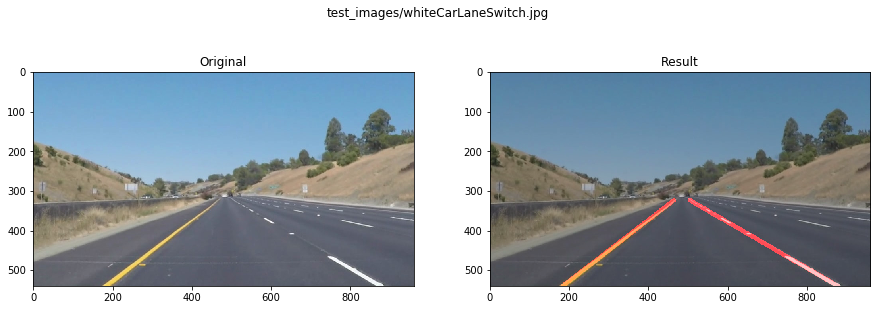

In [14]:
def inspect_find_lane_plot(img_path):
    # Read image
    img = cv2.imread(img_path)
    
    lane_img = find_lane(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    fig = plt.figure(figsize=(15,5))
    fig.suptitle(img_path, fontsize=12)
    
    col = 2
    row = 1
    count = 0
    
    # Plot the result
    count += 1
    fig.add_subplot(row, col, count)
    plt.title('Original')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    count += 1
    fig.add_subplot(row, col, count)
    plt.title('Result')
    plt.imshow(lane_img)
    
# Hough Lines Parameters
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 50     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 30 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments
        
for file in img_files:
# file = 'solidWhiteCurve.jpg'
    path = folder_name + file
    inspect_find_lane_plot(path)

#### Videos
The updated draw_lines() looks very promising on image, lets try on video now

In [15]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = find_lane(image)
    return result

In [20]:
white_output = 'test_videos_output/solidWhiteRight_smooth.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight_smooth.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight_smooth.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:03<00:00, 55.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight_smooth.mp4 

Wall time: 4.64 s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [24]:
yellow_output = 'test_videos_output/solidYellowLeft_smooth.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft_smooth.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft_smooth.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:16<00:00, 37.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft_smooth.mp4 

Wall time: 17.7 s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.



### Reflection

### 1. Describe your pipeline. As part of the description, explain how you modified the draw_lines() function.

1. Convert the input image into grayscale
2. Run Gaussian Blur
3. Use Canny Edge to find all the edges
4. Zone out between leff and right lane for easier inspection of Hough Line result

draw_lines() modification
5. Use liner regression to find out best fit line from from Hough Line results
6. While we have the slope and Y can be determined, we can utilize liner equation to work out the required point of X
7. Draw overlay on images based on X and Y found



### 2. Identify potential shortcomings with your current pipeline

* The vertices of region of interest is a static region
* When the car is turning it can't find the outside lane correctly at all
* It will not work well with chaning lighting condition, especially when it is getting drak and the color infomration for lane marker is not as visiable as under good day light


### 3. Suggest possible improvements to your pipeline

* Based on the camera's field of view, distent and angel from the road to better calculate the region of interest in run-time
* Try to incorporate color in the lane finding pipeline
* Have a calibrate procdure to fit into different lighting and lane marker color conditions